In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import struct
import numpy as np




In [3]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [4]:

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte'
                               % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape((len(labels),28,28))

    return images, labels

In [5]:
X_train, y_train = load_mnist('./data')
                              
X_test, y_test = load_mnist('./data',kind='t10k')
print(X_test.shape,y_test.shape)

(10000, 28, 28) (10000,)


In [6]:
def imgs_show_ne(imgs,row,col):
    imgs = imgs + 0.5
    fig,ax = plt.subplots(nrows=row,ncols=col,sharex=True,sharey=True)
    ax = ax.flatten()
    for i in range(row*col):
        img = imgs[i]
        ax[i].imshow(img,cmap='Greys', interpolation='nearest')
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()

In [7]:
def img_show(img):
    plt.figure(figsize=(1,1))
    plt.imshow(img,cmap='Greys',interpolation='nearest')
    

In [8]:
def imgs_show(imgs,row,col):
    fig,ax = plt.subplots(nrows=row,ncols=col,sharex=True,sharey=True)
    ax = ax.flatten()
    for i in range(row*col):
        img = imgs[i]
        ax[i].imshow(img,cmap='Greys', interpolation='nearest')
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()
    
    

In [9]:
def normal_minist(img):
    return ((img / 255.0) -0.5)*2

In [10]:
def expend_HWC(img):
    return np.expand_dims(img,axis=3)


In [11]:
def to_CHW(img):
    return np.transpose(img,(0,3,1,2))
def to_HWC(img):
    return np.transpose(img,(0,2,3,1))

In [12]:
#只能运行一次
X_train_nor = expend_HWC(X_train)
X_train_nor = normal_minist(X_train_nor)
X_train_nor = to_CHW(X_train_nor)
print(X_train_nor.shape)

X_test_nor = expend_HWC(X_test)
X_test_nor = normal_minist(X_test_nor)
X_test_nor = to_CHW(X_test_nor)
print(X_test_nor.shape)




(60000, 1, 28, 28)
(10000, 1, 28, 28)


In [13]:
eval_index = 0


In [14]:

test_postitive = X_test_nor[y_test == eval_index]
test_nagivate = X_test_nor[y_test != eval_index]
print(test_postitive.shape)
print(test_nagivate.shape)


train_positive = X_train_nor[y_train == eval_index][[0,55,1111,1009,327,128,5000,469,2000,3001]]
# imgs_show(train_positive,2,5)
# train_nagivate = np.concatenate((train_1 , train_2 ,train_3 , train_4 ,train_5 ,
#                                  train_6 , train_7 ,train_8 ,train_9)) 
train_nagivate = X_train_nor[y_train != eval_index]

print(train_nagivate.shape)
print(train_positive.shape)

# imgs_show(train_nagivate[:25],5,5)



(980, 1, 28, 28)
(9020, 1, 28, 28)
(54077, 1, 28, 28)
(10, 1, 28, 28)


In [15]:
shuf_index = np.random.permutation(len(train_nagivate))

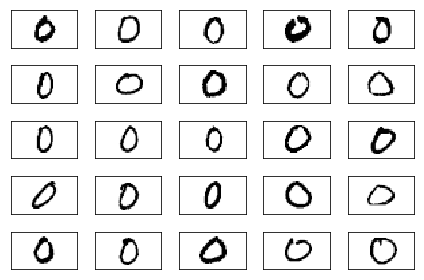

In [106]:
# print(train_positive[0][0])
imgs_show(np.squeeze (test_postitive[:25]),5,5)
# print(train_nagivate[0])

# imgs_show(X_train[y_train != eval_index][50000:50025],5,5)
# print(X_train[y_train != eval_index][0])


In [17]:
def num_flat_features(x):
    size = x.size()[1:]
    num_features =1
        
    for s in size:
        num_features *= s
    return num_features
        

In [44]:
class AutoCodeNet(nn.Module):
    def __init__(self):
        super(AutoCodeNet,self).__init__()
        self.conv1 = nn.Conv2d(1,16,kernel_size=3,stride=2,padding=1)
#         self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,8,kernel_size=3,stride=2,padding=1)
#         self.pool2 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(8,8,kernel_size=3,stride=2,padding=1)
#         self.pool3 = nn.MaxPool2d(2,2,padding=1)
      
            
        
        self.up1 = nn.Upsample(scale_factor = 2,mode='nearest')
        self.conv_d1 = nn.Conv2d(8,8,kernel_size=3,stride=1,padding=1)
        self.up2 = nn.Upsample(scale_factor = 2)
        self.conv_d2 = nn.Conv2d(8,8,kernel_size=3,stride=1)
        self.up3 = nn.Upsample(scale_factor = 2)
        self.conv_d3 = nn.Conv2d(8,16,kernel_size=3,stride=1,padding=1)
        
        self.conv_d4 = nn.Conv2d(16,1,kernel_size=3,stride=1,padding=1)
        
        self.features={}
        
    def decodeForward(self,x):
        #decode
        x = F.relu(self.conv1(x))
        self.features['relu1'] = x
#         x = self.pool1(x)
#         self.features['pool1'] = x
        
        x = F.relu(self.conv2(x))
        self.features['relu2'] = x
#         x = self.pool2(x)
#         self.features['pool2'] = x
        
        x = F.relu(self.conv3(x))
        self.features['relu3'] = x
#         x = self.pool3(x)
#         self.features['pool3'] = x
        return x
    
    def encodeforward(self,x):
        
        x = self.up1(x)
        self.features['up1'] = x
        x = F.relu(self.conv_d1(x))
        self.features['relu_d1'] = x
        
        x = self.up2(x)
        self.features['up2'] = x
        x = F.relu(self.conv_d2(x))
        self.features['relu_d2'] = x
        
        x = self.up3(x)
        self.features['up3'] = x
        x = F.relu(self.conv_d3(x))
        self.features['relu_d3'] = x
        
        x = self.conv_d4(x)
        self.features['conv_d4'] = x
        
        x = F.tanh(x)
        self.features['tanh'] = x
        return x
        
    def forward(self,x):
        #decode
        x = F.relu(self.conv1(x))
        self.features['relu1'] = x
#         x = self.pool1(x)
#         self.features['pool1'] = x
        
        x = F.relu(self.conv2(x))
        self.features['relu2'] = x
#         x = self.pool2(x)
#         self.features['pool2'] = x
        
        x = F.relu(self.conv3(x))
        self.features['relu3'] = x
#         x = self.pool3(x)
#         self.features['pool3'] = x
        
        
        #encode
        
        x = self.up1(x)
        self.features['up1'] = x
        x = F.relu(self.conv_d1(x))
        self.features['relu_d1'] = x
        
        x = self.up2(x)
        self.features['up2'] = x
        x = F.relu(self.conv_d2(x))
        self.features['relu_d2'] = x
        
        x = self.up3(x)
        self.features['up3'] = x
        x = F.relu(self.conv_d3(x))
        self.features['relu_d3'] = x
        
        x = self.conv_d4(x)
        self.features['conv_d4'] = x
        
        x = F.tanh(x)
        self.features['tanh'] = x
        return x
        
        
        
        
        
        
        

In [45]:
net_auto = AutoCodeNet()
# print(net_auto)
inp1 = Variable(torch.randn((10,1,28,28)))

out1 = net_auto(inp1)
print(out1.size())

print(net_auto.features['relu1'].size())
# print(net_auto.features['pool1'].size())
print(net_auto.features['relu2'].size())
# print(net_auto.features['pool2'].size())
print(net_auto.features['relu3'].size())
# print(net_auto.features['pool3'].size())

print("encode:")
print(net_auto.features['up1'].size())
print(net_auto.features['relu_d1'].size())
print(net_auto.features['up2'].size())
print(net_auto.features['relu_d2'].size())
print(net_auto.features['up3'].size())
print(net_auto.features['relu_d3'].size())
print(net_auto.features['conv_d4'].size())
print(net_auto.features['tanh'].size())



torch.Size([10, 1, 28, 28])
torch.Size([10, 16, 14, 14])
torch.Size([10, 8, 7, 7])
torch.Size([10, 8, 4, 4])
encode:
torch.Size([10, 8, 8, 8])
torch.Size([10, 8, 8, 8])
torch.Size([10, 8, 16, 16])
torch.Size([10, 8, 14, 14])
torch.Size([10, 8, 28, 28])
torch.Size([10, 16, 28, 28])
torch.Size([10, 1, 28, 28])
torch.Size([10, 1, 28, 28])


In [20]:
def getnext_signle(train_x,batch_size):
    batchs = len(train_x) // batch_size
    print(len(train_x),batchs)

    for i in range(batchs):
        x = train_x[batch_size * i : batch_size * (i+1)]
        
        yield x

In [21]:
def getnext(train_x,train_y,batch_size):
    batchs = len(train_y) // batch_size
    print(len(train_y),batchs)

    for i in range(batchs):
        x = train_x[batch_size * i : batch_size * (i+1)]
        y = train_y[batch_size * i : batch_size * (i+1)]
        yield x,y
        

In [22]:
def get_nagivate_next(train_positive,train_nagivate):
    batch_size = len(train_positive) 
    batchs = len(train_nagivate) // batch_size
    print(len(train_nagivate),batchs)
    
    for i in range(batchs):
        x = np.concatenate((train_positive,train_nagivate[batch_size * i : batch_size * (i+1)]))
        y = np.concatenate((np.zeros(batch_size),np.ones(batch_size)))
        shuf_index = np.random.permutation(len(y))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x ,y 
        

In [23]:
def get_nagivate_batch_next(train_positive,train_nagivate,batch_size):
#     batch_size = len(train_positive) 
    batchs = len(train_nagivate) // batch_size
    print(len(train_nagivate),batchs)
    
    for i in range(batchs):
        x = np.concatenate((train_positive,train_nagivate[batch_size * i : batch_size * (i+1)]))
        y = np.concatenate((np.zeros(len(train_positive)),np.ones(len(train_nagivate))))
        shuf_index = np.random.permutation(len(x))
        x = x[shuf_index]
        y = y[shuf_index]
        
        
        yield x ,y 

130 2
(74, 1, 28, 28)
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  0.  1.  1.  1.  1.
  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.
  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  0.  1.
  1.  1.]


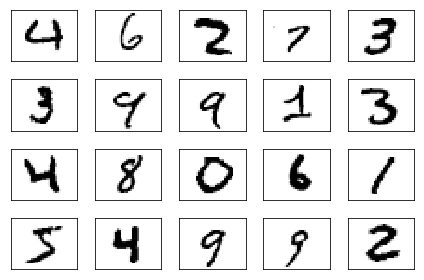

(74, 1, 28, 28)
[ 1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.
  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  1.  1.  1.  1.  1.
  1.  1.]


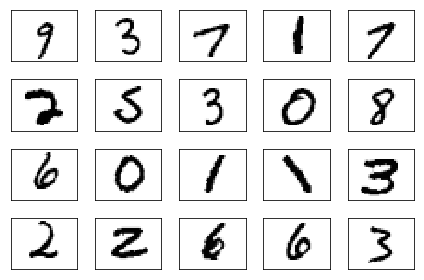

In [24]:
datas = get_nagivate_batch_next(train_positive,train_nagivate[:130],64)
for x,y in datas:
    print(x.shape)
    
    print(y)
    imgs_show(np.squeeze( x),4,5)


In [36]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(666)
# device = torch.device("cuda" if use_cuda else "cpu")
net_auto.cuda()
net_auto.double()


criterion = nn.MSELoss()
optimizer = optim.SGD(net_auto.parameters(),lr=0.0003,momentum=0.9)


In [ ]:

auto_set = np.concatenate((train_nagivate,train_positive))
shuf_index = np.random.permutation(len(auto_set))

In [37]:
#X_train_nor

net_auto.train()
for epoch in range(50):
    datas = get_nagivate_batch_next(train_positive,train_nagivate,86)
    trainloss = 0
    
    for x,y in datas:
        inputs = Variable(torch.from_numpy(x)).cuda()
#         print(inputs.size())
        optimizer.zero_grad()
        output = net_auto(inputs)
#         print(output.size())
        loss = criterion(output,inputs)
        trainloss += loss
        loss.backward()
        optimizer.step()
        
    print('%d  loss: %.3f' % (epoch ,  trainloss))
torch.save(net_auto,'model_autoEncode5.pkl')

54077 628
0  loss: 21.672
54077 628
1  loss: 21.663
54077 628
2  loss: 21.654
54077 628


KeyboardInterrupt: 

In [ ]:
net_auto.train()
for epoch in range(100):
    datas = get_nagivate_next(train_positive,train_nagivate)
    trainloss = 0
    
    for x,y in datas:
        inputs, labels = Variable(torch.from_numpy(x)).cuda(), Variable(torch.from_numpy(y).long()).cuda()
#         print(labels)
        optimizer.zero_grad()
        output = net_auto(inputs)
        print(output.size())
        loss = criterion(output,inputs)
        trainloss += loss
        loss.backward()
        optimizer.step()
        
    print('%d  loss: %.3f' % (epoch ,  trainloss))
torch.save(net_auto,'model_autoEncode3.pkl')

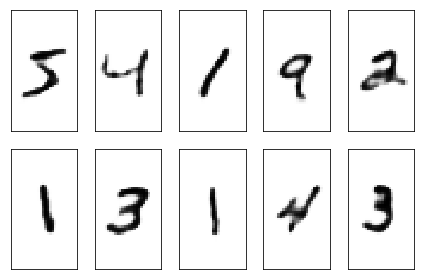

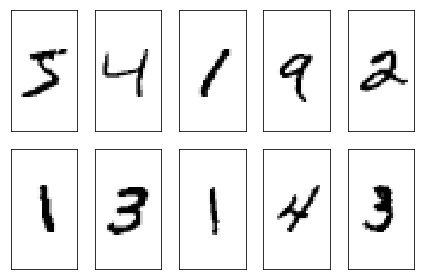


-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-0.9999
-0.9976
-0.9075
 0.1128
 0.7853
 0.8415
 0.5525
-0.5726
-0.9690
-0.9996
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
[torch.cuda.DoubleTensor of size 28 (GPU 0)]


-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-0.9137
 0.4902
 0.9843
-0.4510
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
-1.0000
[torch.cuda.DoubleTensor of size 28 (GPU 0)]



In [39]:
net_auto = torch.load('model_autoEncode5.pkl')
net_auto.cuda()
net_auto.eval()

inputs = Variable(torch.from_numpy( train_nagivate[:10])).cuda()
outputs = net_auto(inputs)
imgs_show(np.squeeze(outputs.data),2,5)
imgs_show(np.squeeze(inputs.data),2,5)
    
print(outputs.data[0][0][12])
print(inputs.data[0][0][12])

    
    


 1.3686  2.3722  2.9578  1.8307
 1.3424  1.7994  1.5493  1.0588
 0.9132  1.7113  1.6656  0.5341
 0.9398  1.1297  1.2635  1.0153
[torch.cuda.DoubleTensor of size 4x4 (GPU 0)]


 1.3686  2.2217  2.5382  1.9252
 1.1927  2.2178  1.9809  0.7782
 1.1927  1.8153  1.8864  1.2325
 1.2695  1.4395  1.6571  1.0547
[torch.cuda.DoubleTensor of size 4x4 (GPU 0)]



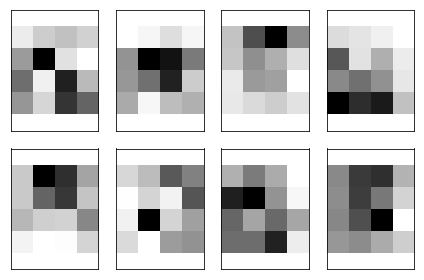

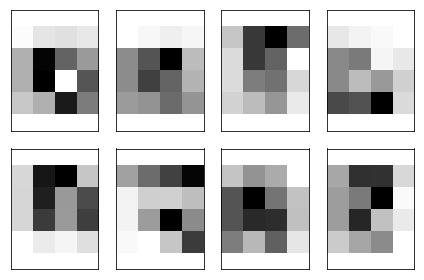


(0 ,.,.) = 
  1.3686  2.3722  2.9578  1.8307
  1.3424  1.7994  1.5493  1.0588
  0.9132  1.7113  1.6656  0.5341
  0.9398  1.1297  1.2635  1.0153
[torch.cuda.DoubleTensor of size 1x4x4 (GPU 0)]


(0 ,.,.) = 
  1.3686  2.2217  2.5382  1.9252
  1.1927  2.2178  1.9809  0.7782
  1.1927  1.8153  1.8864  1.2325
  1.2695  1.4395  1.6571  1.0547
[torch.cuda.DoubleTensor of size 1x4x4 (GPU 0)]

torch.Size([1, 1, 28, 28])


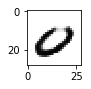

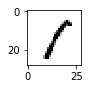

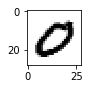

In [105]:
net_auto = torch.load('model_autoEncode5.pkl')
net_auto.cuda()
net_auto.eval()


inputs1,inputs2 = Variable(torch.from_numpy( train_positive[1:2])).cuda(), \
    Variable(torch.from_numpy( X_train_nor[y_train==1][580:581])).cuda()
#     outputs = net_auto(inputs)
#     img_show(np.squeeze(outputs.data))
    
middle1 = net_auto.decodeForward(inputs1)
middle2 = net_auto.decodeForward(inputs2)
print(middle1.data[0][2])
print(middle2.data[0][2])
imgs_show(np.squeeze(middle1.data),2,4)
imgs_show(np.squeeze(middle2.data),2,4)
    
middle1.data[:,5,0,:] = middle1.data[:,5,0,:] * (-1)
    
print(middle1.data[:,2,:,:])
print(middle2.data[:,2,:,:])

out = net_auto.encodeforward(middle1)
print(out.size())
img_show(np.squeeze(out.data))
img_show(np.squeeze(inputs2.data))
img_show(np.squeeze(inputs1.data))



In [ ]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
net2 = autoencoder()
net2.cuda()
net2.double()

criterion = nn.MSELoss()
optimizer = optim.SGD(net2.parameters(),lr=0.001,momentum=0.9)


In [ ]:
net2.train()
for epoch in range(20):
    datas = get_nagivate_next(train_positive,train_nagivate)
    trainloss = 0
    
    for x,y in datas:
        inputs, labels = Variable(torch.from_numpy(x)).cuda(), Variable(torch.from_numpy(y).long()).cuda()
#         print(labels)
        optimizer.zero_grad()
        output = net2(inputs)
#         print(output.size())
        loss = criterion(output,inputs)
        trainloss += loss
        loss.backward()
        optimizer.step()
        
    print('%d  loss: %.3f' % (epoch ,  trainloss))
torch.save(net2,'model_autoEncode2.pkl')